In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold # import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_selection import SelectFromModel

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import yellowbrick as yb

In [2]:
from src.utilities import timeseries_train_test_split

### Predict Energy consumption

In [3]:
dataset = pd.read_csv('../../data/data1/processed/dataset_seattle.csv')

In [4]:
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Cooling:Electricity [kW](Hourly)',
       'Date/Time', 'Electricity:Facility [kW](Hourly)',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Labor Day',
       'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day

In [5]:
dataset_numeric = dataset[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'location_id', 'building_id', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_WA_SEATTLE']]

data = dataset[['Cooling:Electricity [kW](Hourly)',
                'Electricity:Facility [kW](Hourly)',
                'Fans:Electricity [kW](Hourly)',
                'Gas:Facility [kW](Hourly)',
                'InteriorEquipment:Gas [kW](Hourly)',
                'Water Heater:WaterSystems:Gas [kW](Hourly)',
                'RefBldgLargeHotelNew',
                'RefBldgMediumOfficeNew',
                'temperatureHigh',
                'Electricity:Facility [kW](Hourly)_lag',
                'Electricity:Facility_delta_current_lag',
                'Electricity:Facility [kW](Hourly)_future']]

In [6]:
dataset_numeric.describe()

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Hourly)_lag,Electricity:Facility [kW](Hourly)_future,Electricity:Facility_delta_current_lag,Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),...,RefBldgPrimarySchoolNew,RefBldgQuickServiceRestaurantNew,RefBldgSecondarySchoolNew,RefBldgSmallHotelNew,RefBldgSmallOfficeNew,RefBldgStand-aloneRetailNew,RefBldgStripMallNew,RefBldgSuperMarketNew,RefBldgWarehouseNew,USA_WA_SEATTLE
count,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,...,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.0
mean,37.778688,180.264885,180.122684,180.245595,0.142200,15.771051,103.506153,1.335365,74.133008,53.220947,...,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062350,1.0
std,101.557673,288.659340,288.534918,288.664747,395.785370,25.967284,191.686101,7.787510,169.302260,83.215305,...,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.241791,0.0
min,0.000000,1.925019,1.925019,1.925019,-1360.180141,0.000000,0.000000,0.000000,0.000000,1.011600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,23.049338,23.041895,23.047336,-83.752714,0.252635,3.021100,0.000000,0.000000,8.092797,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,55.579849,55.575392,55.575392,12.677655,3.659254,26.929976,0.000000,6.447821,20.643869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,8.984801,193.096680,192.900699,193.050216,96.753881,24.360913,101.032736,0.000000,67.459303,53.238744,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,458.047681,1502.776534,1502.776534,1502.776534,1359.682138,156.696697,3150.315818,219.856108,3136.861981,448.566544,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [7]:
corr_matrix = dataset_numeric.corr()
corr_matrix["Electricity:Facility [kW](Hourly)_future"].sort_values(ascending=False)

Electricity:Facility [kW](Hourly)_future      1.000000
RefBldgLargeHotelNew                          0.724359
Water Heater:WaterSystems:Gas [kW](Hourly)    0.650177
RefBldgMediumOfficeNew                        0.402842
InteriorEquipment:Gas [kW](Hourly)            0.276767
Electricity:Facility [kW](Hourly)_lag         0.244781
Heating:Electricity [kW](Hourly)              0.161458
Gas:Facility [kW](Hourly)                     0.144028
InteriorEquipment:Electricity [kW](Hourly)    0.098185
RefBldgSmallHotelNew                          0.080537
RefBldgLargeOfficeNew                         0.072545
InteriorLights:Electricity [kW](Hourly)       0.065154
Electricity:Facility [kW](Hourly)             0.059379
Fans:Electricity [kW](Hourly)                 0.038090
is_weekend                                    0.035386
temperatureHigh                               0.028246
Monday                                        0.026009
Sunday                                        0.024994
Tuesday   

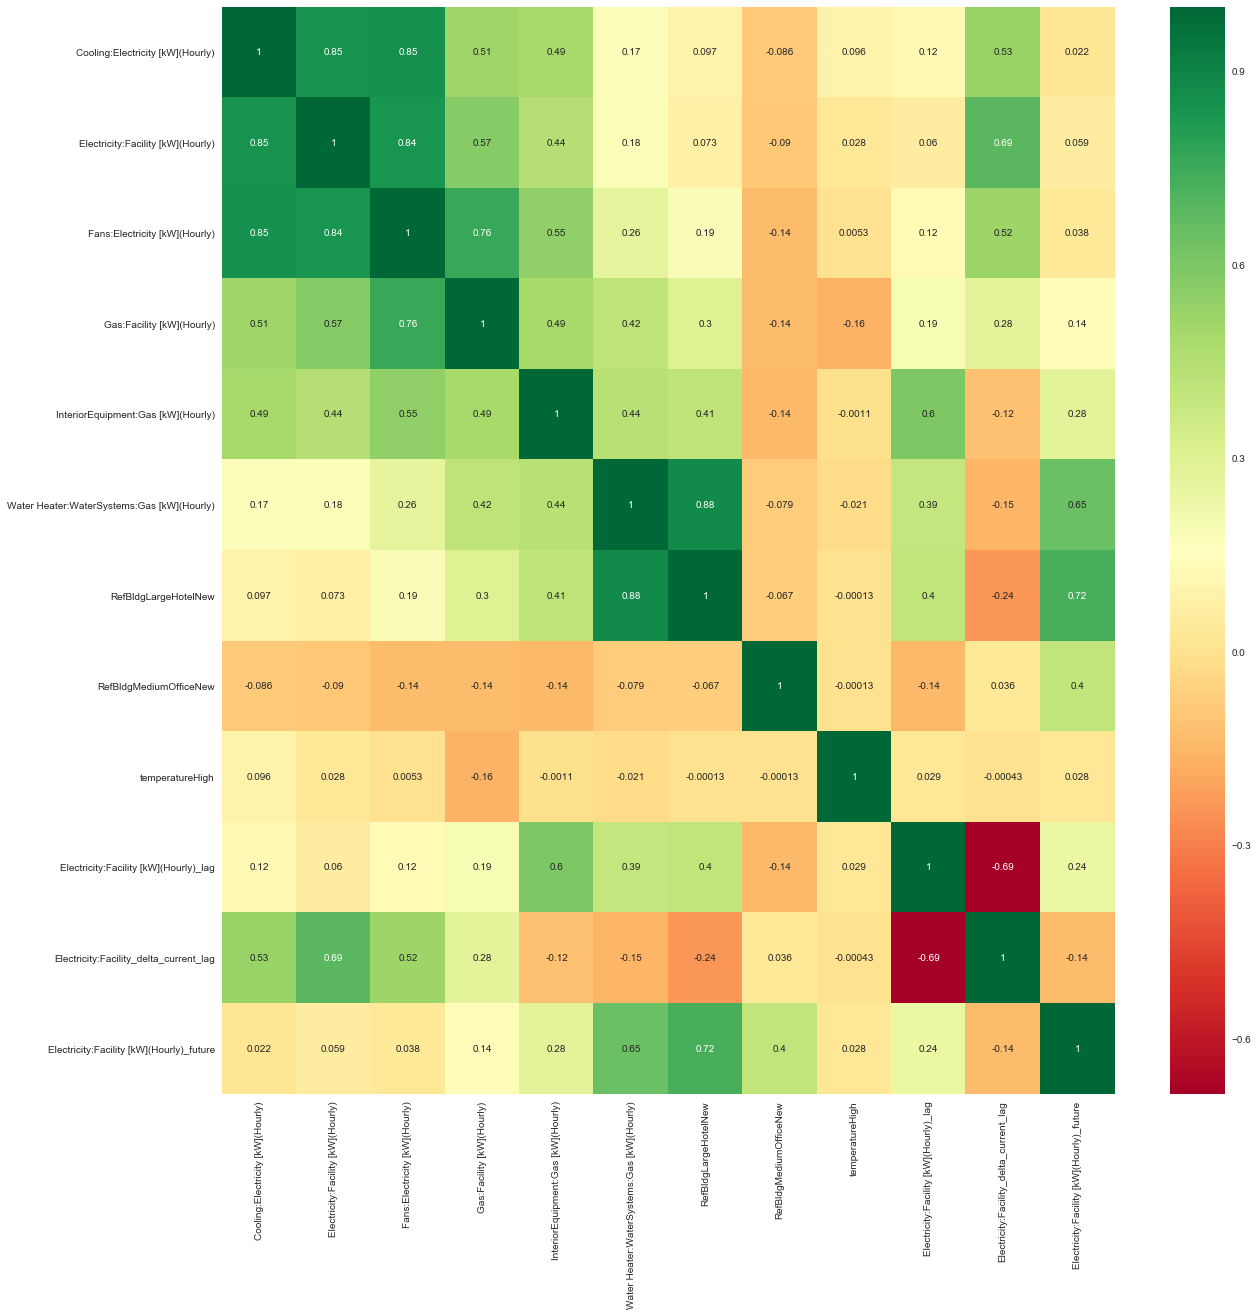

In [8]:
X = data.iloc[:,0:10]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

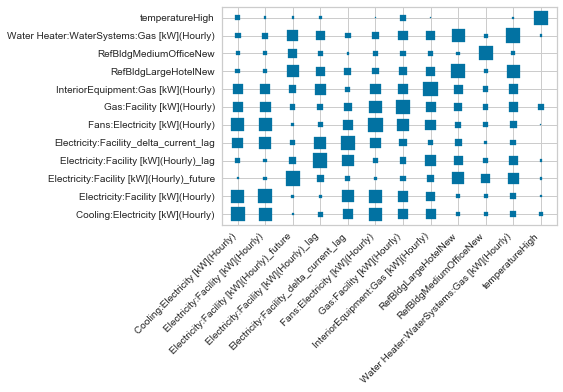

<Figure size 1440x1440 with 0 Axes>

In [9]:
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    plt.figure(figsize=(20,20))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 200
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
columns = ['Cooling:Electricity [kW](Hourly)',
                'Electricity:Facility [kW](Hourly)',
                'Fans:Electricity [kW](Hourly)',
                'Gas:Facility [kW](Hourly)',
                'InteriorEquipment:Gas [kW](Hourly)',
                'Water Heater:WaterSystems:Gas [kW](Hourly)',
                'RefBldgLargeHotelNew',
                'RefBldgMediumOfficeNew',
                'temperatureHigh',
                'Electricity:Facility [kW](Hourly)_lag',
                'Electricity:Facility_delta_current_lag',
                'Electricity:Facility [kW](Hourly)_future'] 
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

In [10]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
dataset_numeric_scaling = dataset_numeric[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover']]
scaled_df = scaler.fit_transform(dataset_numeric_scaling)
scaled_df = pd.DataFrame(scaled_df, columns=['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover'])

one_hot_encoded_data = dataset_numeric[['Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_WA_SEATTLE']]

/Users/rnishtala/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rnishtala/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [11]:
processed_data = pd.concat((scaled_df, one_hot_encoded_data), axis=1)

In [12]:
processed_data.columns

Index(['Cooling:Electricity [kW](Hourly)', 'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'is_weekend',
       'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', '

In [13]:
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                            'InteriorEquipment:Electricity [kW](Hourly)',
                            'Fans:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility_delta_current_lag',
                           'Heating:Electricity [kW](Hourly)',
                            'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_WA_SEATTLE',
        'time', 'sunriseTime', 'sunsetTime']]

dataset_labels = processed_data['Electricity:Facility [kW](Hourly)_future']

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2)
X_train, X_test, y_train, y_test = timeseries_train_test_split(dataset_features, dataset_labels, test_size=0.2)

Linear Regression model
Mean Squared Error: 0.158
Coefficient of Determination: 0.839
Coefficients: [ 1.15006094e-01  3.34532927e-02  1.32988185e-01 -1.61251291e-02
  1.57587925e+11 -1.57519999e+11 -2.16071288e+11  2.66430998e-02
  4.05474129e-02  8.83435612e-02 -6.28076840e-03  1.45338232e-02
 -3.10332188e-03 -2.54442005e-03 -3.78011069e-03 -1.31325282e-01
 -1.67708163e-02 -1.89436486e-01  2.56593489e-02 -1.35950837e-02
 -1.39517460e-02  3.89330970e-03  7.31960531e-03  2.81819282e-03
 -3.70823999e-02 -2.60853334e+10 -6.80049306e-03  1.27652471e+10
  1.27652471e+10  3.88505805e+10  3.88505805e+10  1.27652471e+10
  1.27652471e+10  1.27652471e+10  1.07361982e+11  1.07361982e+11
  1.07361982e+11  1.07361982e+11  1.07361982e+11  1.07361982e+11
  1.07361982e+11  1.07361982e+11  1.07361982e+11  1.07361982e+11
  1.07361982e+11  1.07361982e+11  1.07361982e+11  1.07361982e+11
  1.07361982e+11  1.07361982e+11  2.16840434e-18 -6.10078959e+01
  2.50936142e+01  3.59178976e+01]


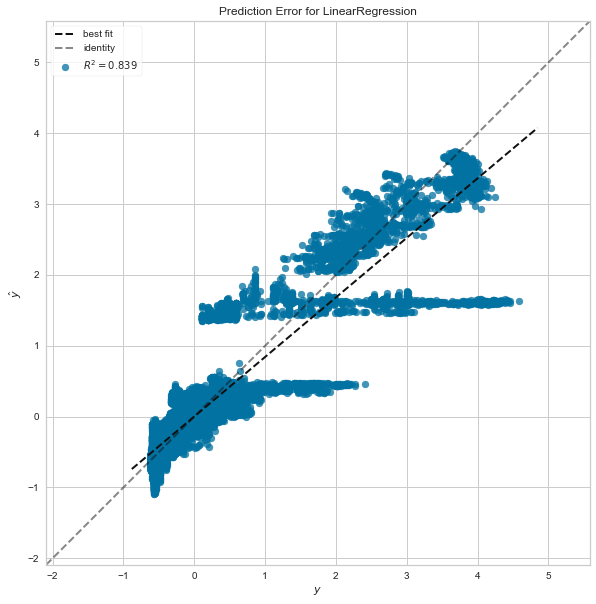

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2)
from yellowbrick.regressor import PredictionError
model = LinearRegression(normalize=True)
est = model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
print('Coefficients: {}'.format(model.coef_))
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Ridge model
Mean Squared Error: 0.175
Coefficient of Determination: 0.821


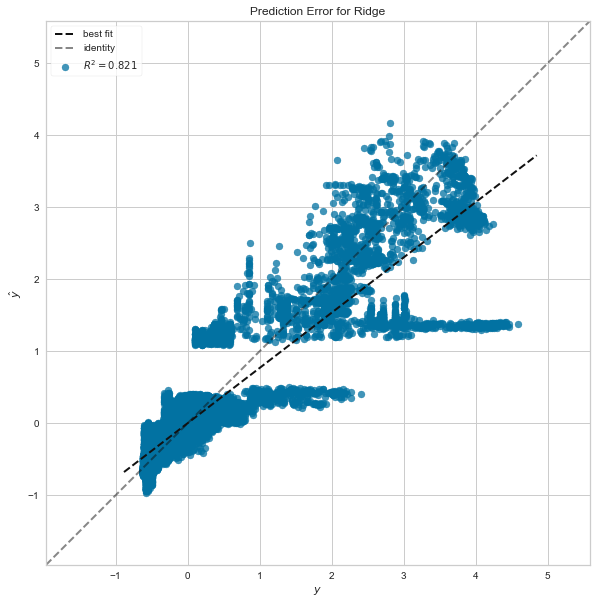

In [16]:
# X_train, X_test, y_train, y_test = timeseries_train_test_split(dataset_features, dataset_labels, test_size=0.2)
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)

expected = y_test
predicted = ridge.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(ridge, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()         

Ridge model
Mean squared error = 0.158
R2 score = 0.839


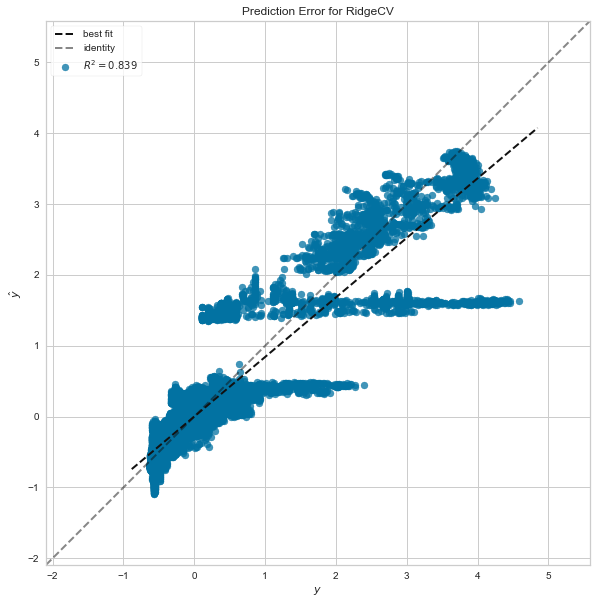

In [17]:
regr_cv = RidgeCV(alphas=[0.5, 100, 1000])
regr_cv.fit(X_train, y_train)

expected = y_test
predicted = regr_cv.predict(X_test)

print('Ridge model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(regr_cv, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

In [18]:
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
expected = y_test
predicted = regr_trans.predict(X_test)

print('Transformed target regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Transformed target regressor
Mean squared error = 0.163
R2 score = 0.834


Gradient boosting regressor
Mean squared error = 0.162
R2 score = 0.835


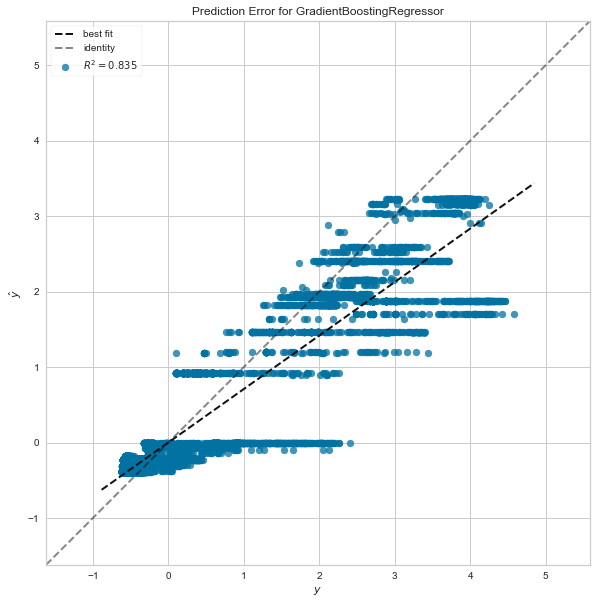

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
gb.fit(X_train,y_train)
expected = y_test
predicted = gb.predict(X_test)

print('Gradient boosting regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(gb, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Lasso
Mean squared error = 0.603
R2 score = 0.384


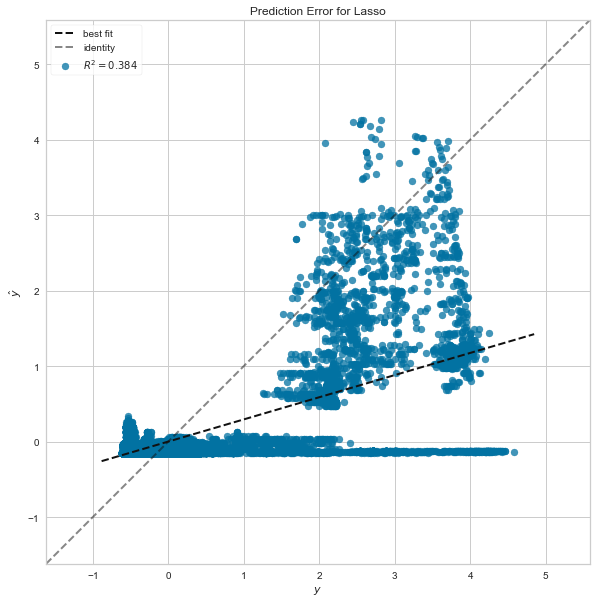

In [20]:
lasso = Lasso(alpha=0.2, max_iter=10e5)
lasso.fit(X_train,y_train)
expected = y_test
predicted = lasso.predict(X_test)

print('Lasso')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(lasso, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [21]:
elastic = ElasticNet(alpha=0.15, max_iter=10e5)
elastic.fit(X_train,y_train)
expected = y_test
predicted = elastic.predict(X_test)

print('Elastic')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Elastic
Mean squared error = 0.511
R2 score = 0.478


knn
Mean squared error = 0.078
R2 score = 0.920


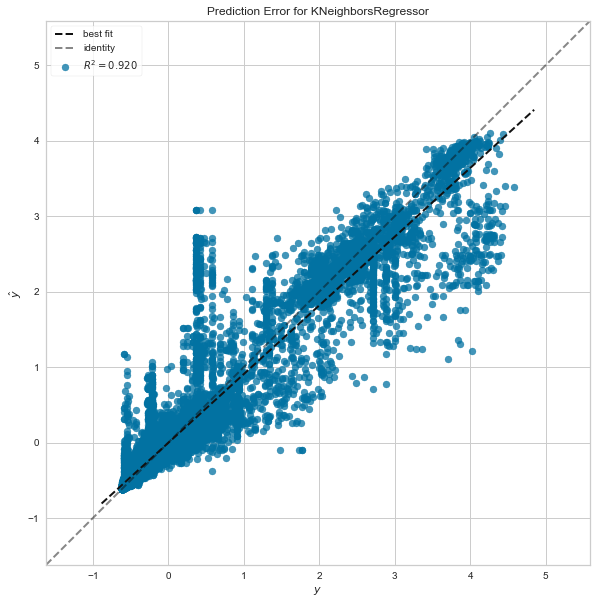

In [22]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(X_train,y_train)
expected = y_test
predicted = knn.predict(X_test)

print('knn')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(knn, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Random Forest Regressor
Mean squared error = 0.131
R2 score = 0.866


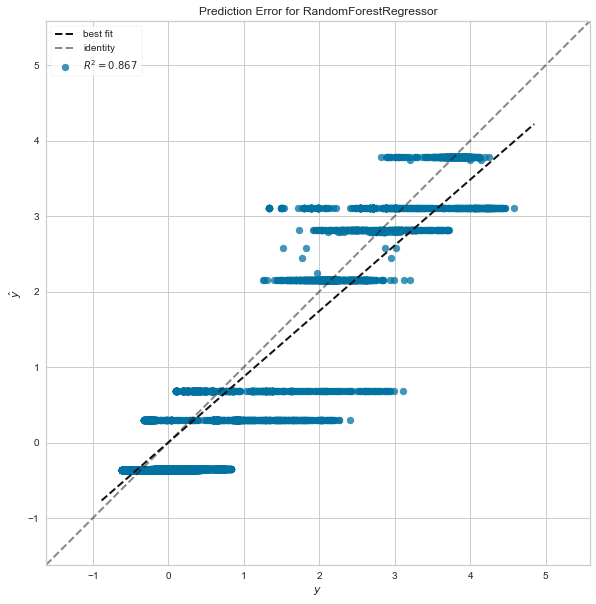

In [23]:
random_forest = RandomForestRegressor(n_estimators=50, max_depth=3)
random_forest.fit(X_train,y_train)
expected = y_test
predicted = random_forest.predict(X_test)

print('Random Forest Regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(random_forest, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

## Feature Analysis and Selection

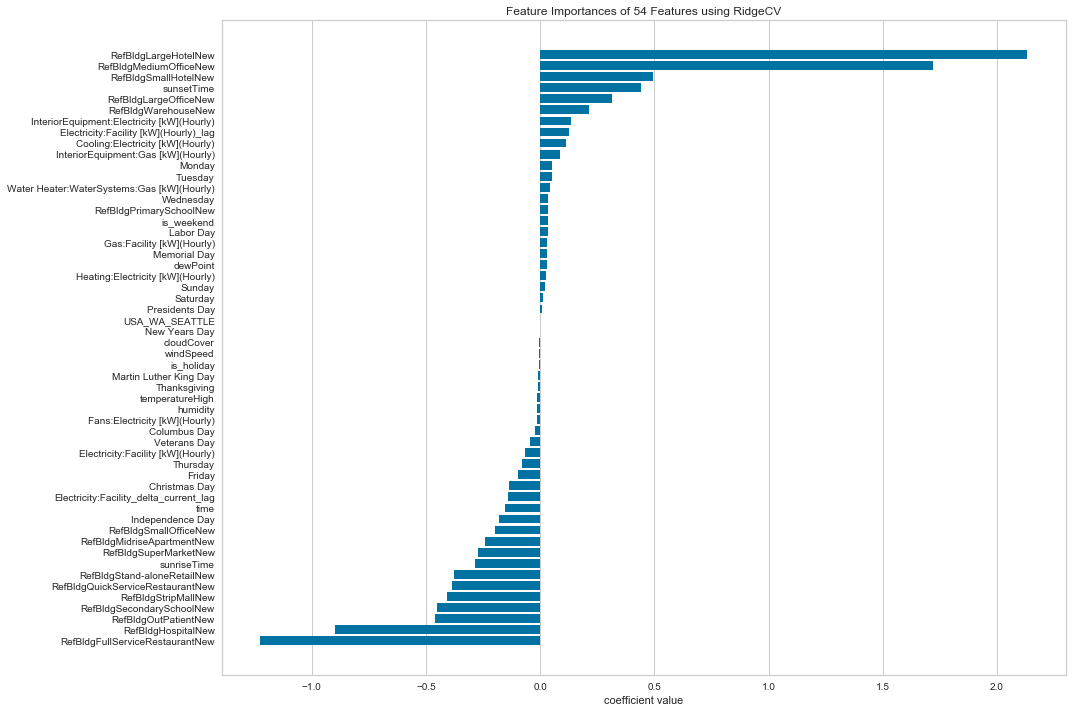

In [24]:
from yellowbrick.features import FeatureImportances

# model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(regr_cv, size=(1080, 720), relative=False)

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

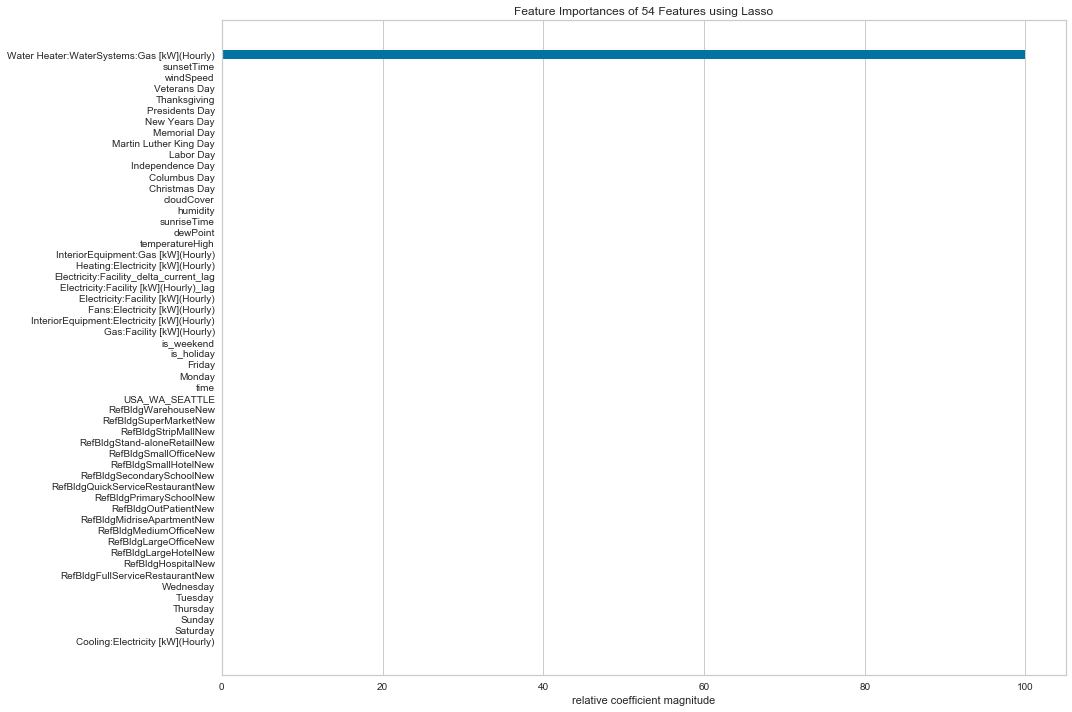

In [25]:
viz = FeatureImportances(lasso, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

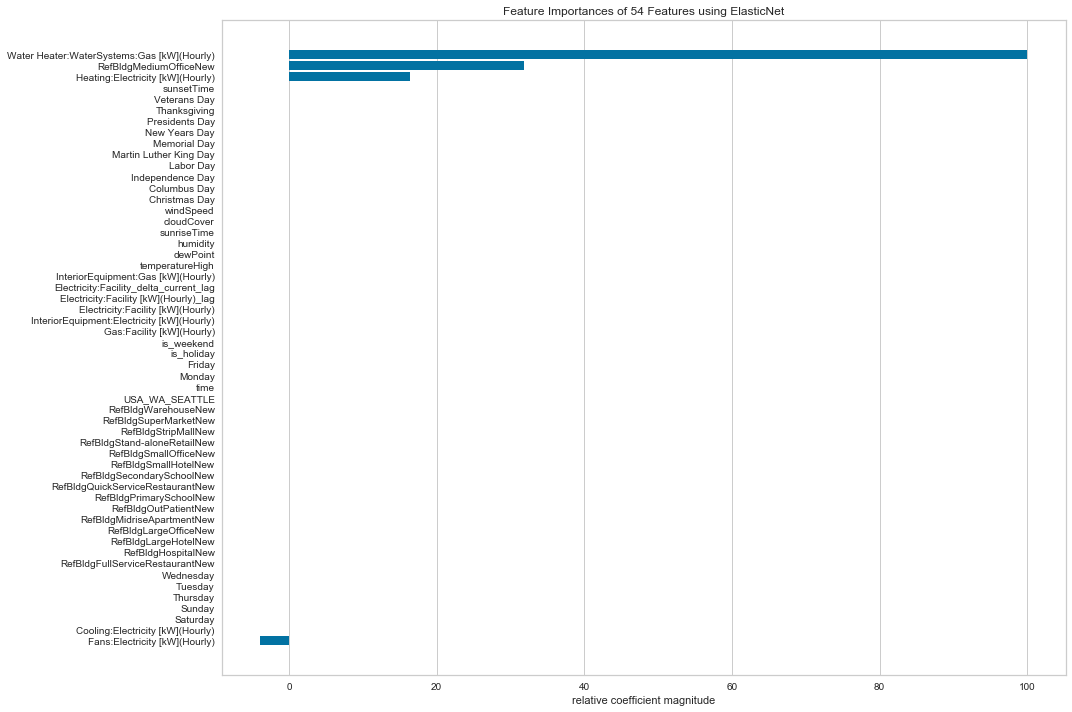

In [26]:
viz = FeatureImportances(elastic, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

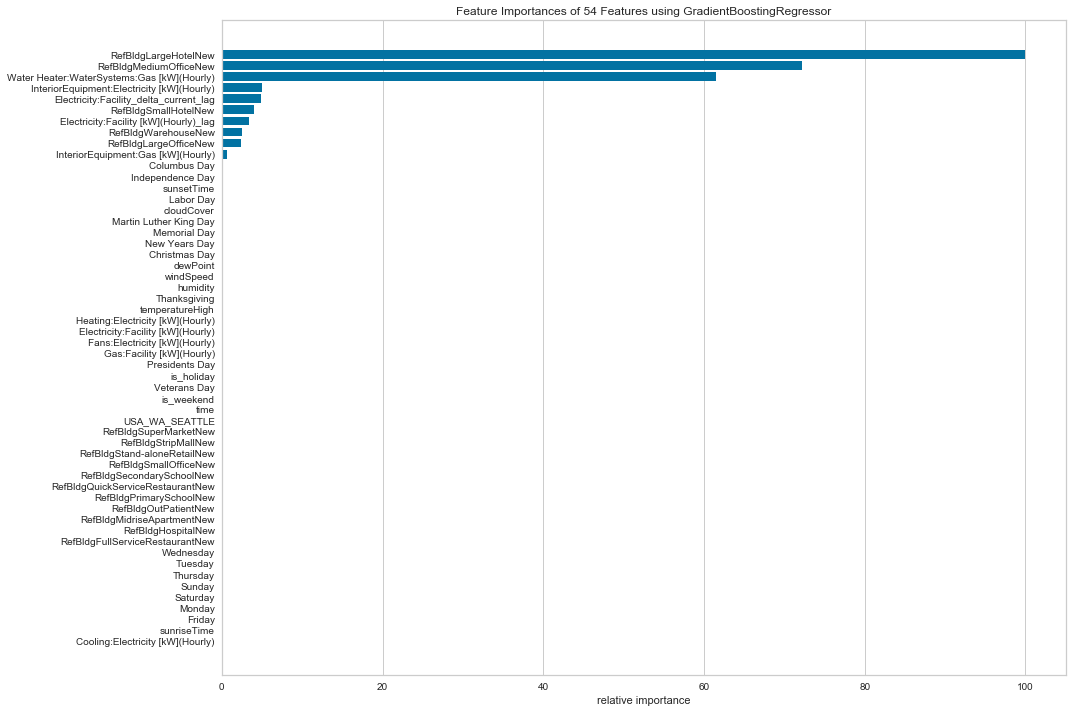

In [27]:
viz = FeatureImportances(gb, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

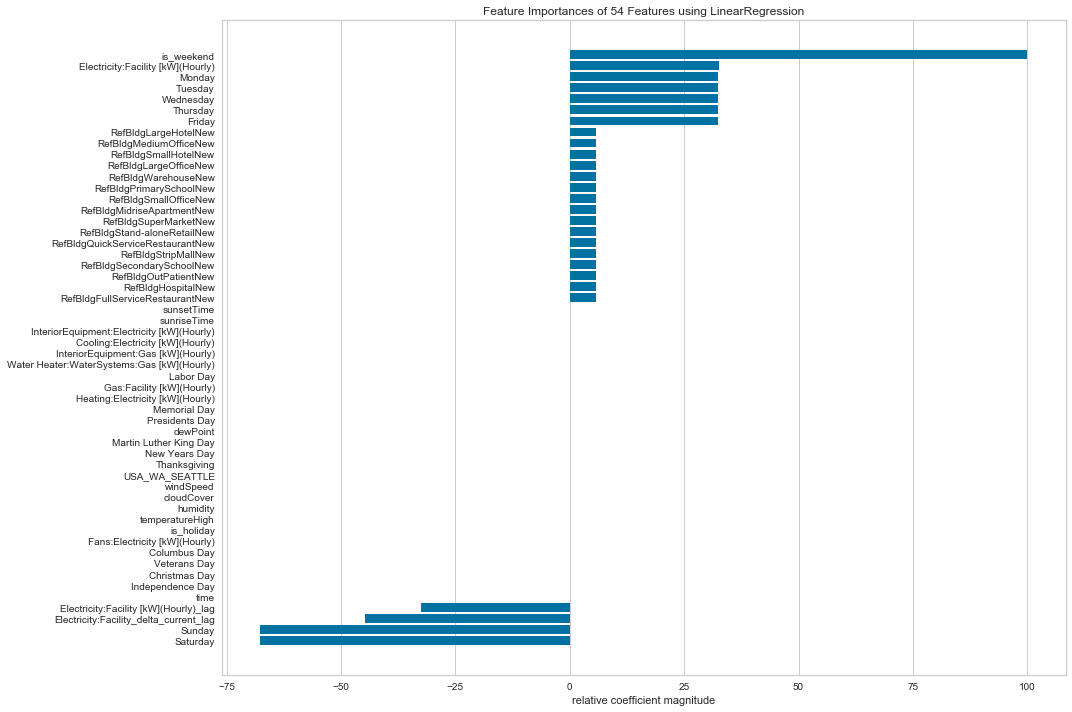

In [28]:
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

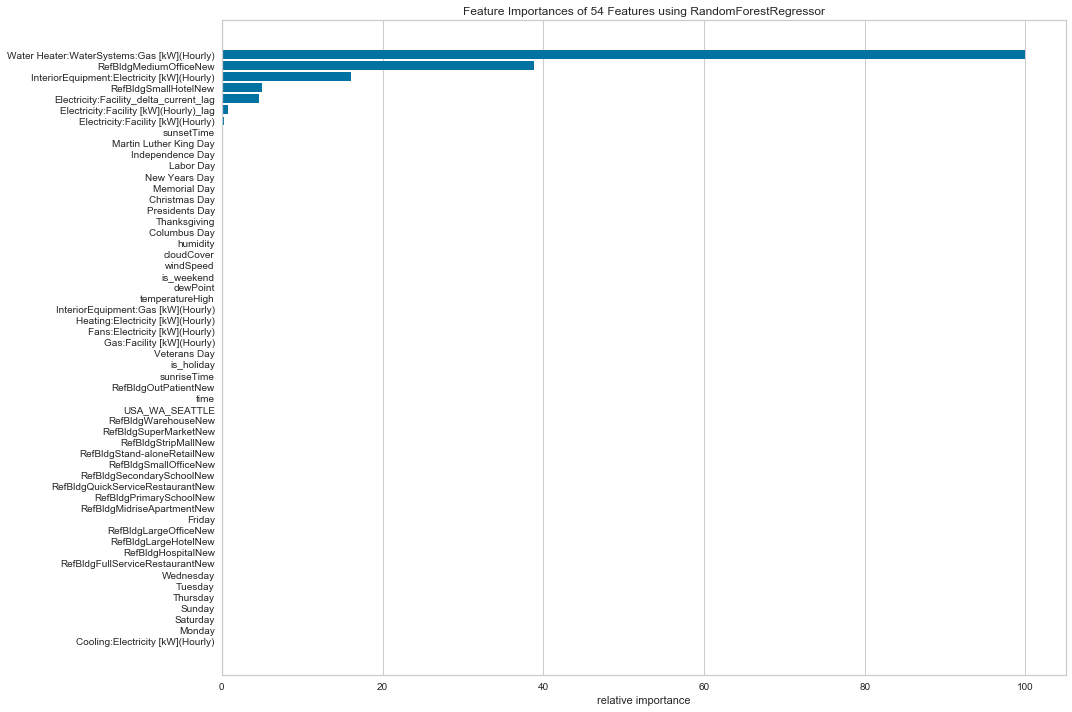

In [29]:
viz = FeatureImportances(random_forest, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

## Residual plots

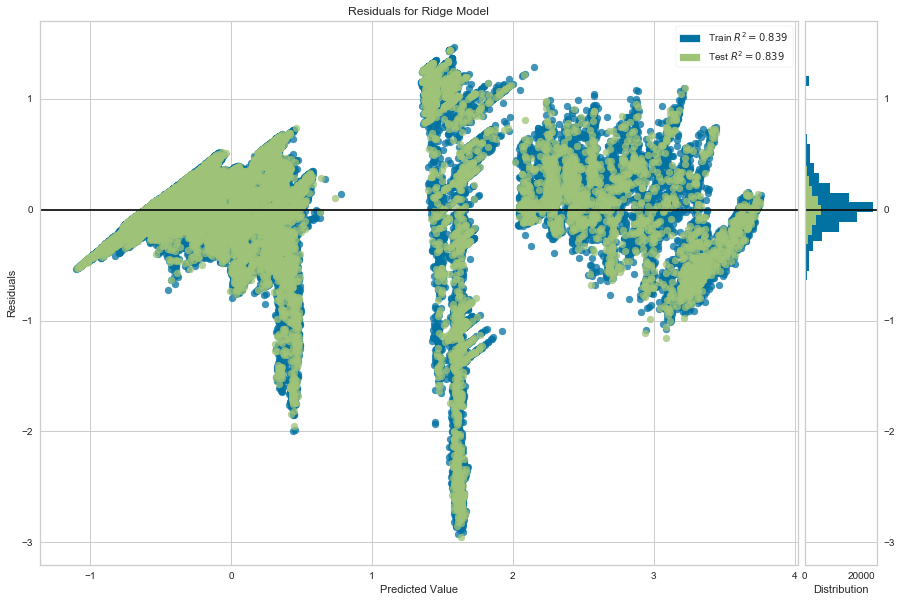

In [30]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

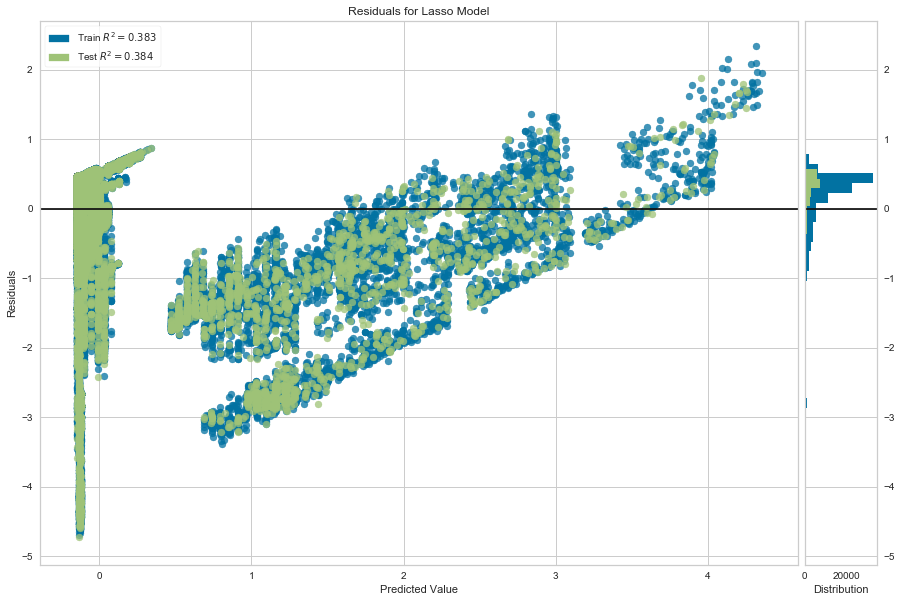

In [31]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = Lasso(alpha=0.2, max_iter=10e5)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

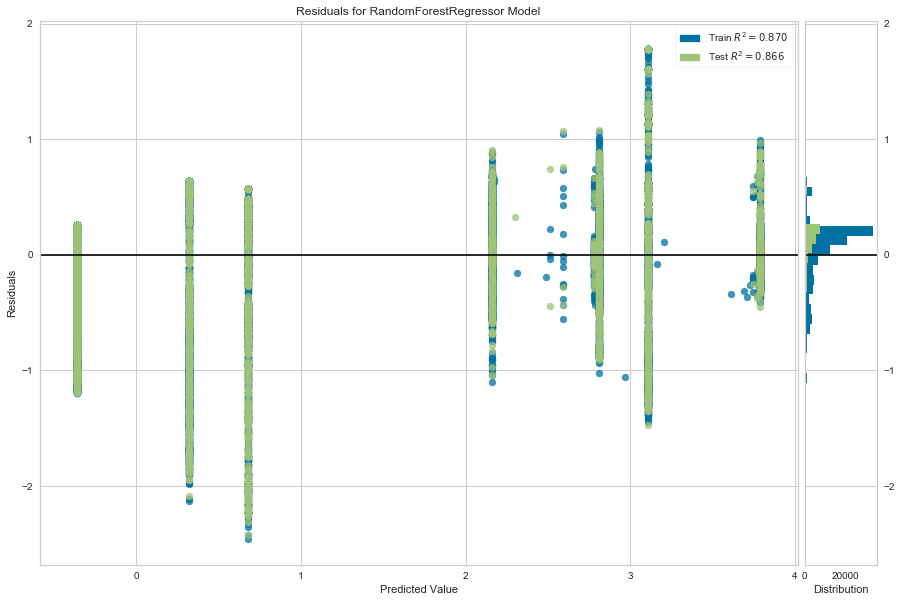

In [32]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = RandomForestRegressor(n_estimators=50, max_depth=3)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

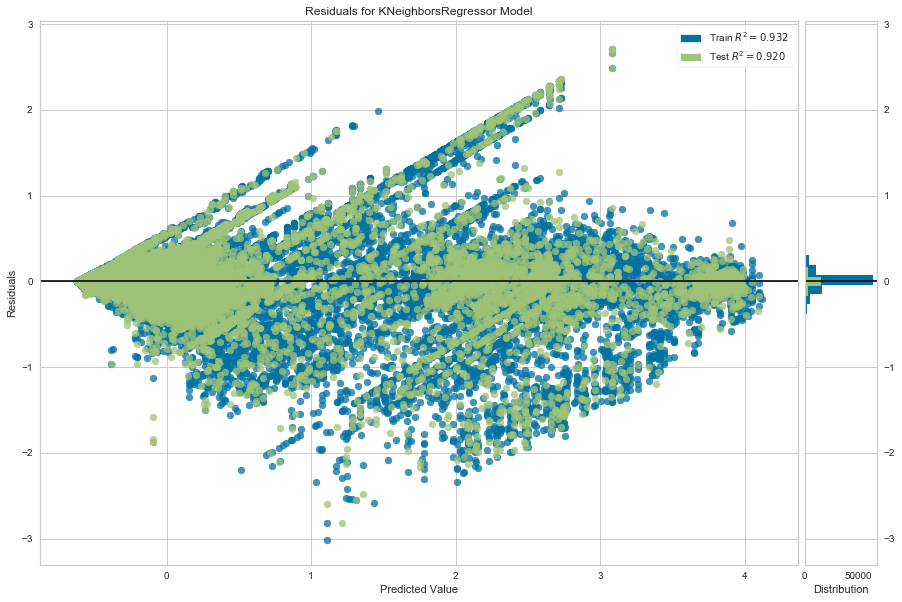

In [33]:
from sklearn.neighbors import KNeighborsRegressor

from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = KNeighborsRegressor(n_neighbors=15)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

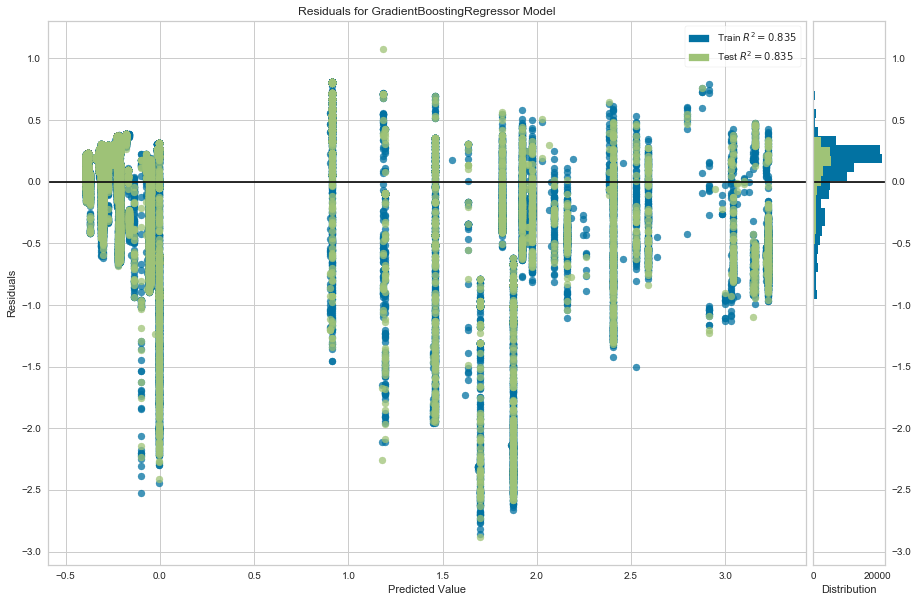

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
gb = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
visualizer = ResidualsPlot(gb, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data